In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from six.moves import range
import random
import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
import urllib    

tar_data_list=['train.tar.gz','test.tar.gz']
for sample_data in tar_data_list:
    print ("Size of "+sample_data +" : ",urllib.urlopen(url+sample_data).info()['Content-Length'])   

Size of train.tar.gz :  404141560
Size of test.tar.gz :  276555967


In [3]:
#download full numbers as format 1, train.tar.gz, test.tar.gz, extra.tar.gz
def maybe_download(filename, expected_bytes):
#   """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo_size = os.stat(filename).st_size
  if statinfo_size == expected_bytes:
    print ('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename
    
train_filename = maybe_download('train.tar.gz',404141560)  #check download file size with originale file size

test_filename = maybe_download('test.tar.gz',276555967)  

Found and verified train.tar.gz
Found and verified test.tar.gz


In [4]:
data_list=['train_32x32.mat','test_32x32.mat','extra_32x32.mat']
for sample_data in data_list:
    print ("Size of "+sample_data +" : ",urllib.urlopen(url+sample_data).info()['Content-Length'])   

Size of train_32x32.mat :  182040794
Size of test_32x32.mat :  64275384
Size of extra_32x32.mat :  1329278602


In [5]:
train_matfile = maybe_download('train_32x32.mat',182040794)
test_matfile = maybe_download('test_32x32.mat',64275384)
extra_matfile = maybe_download('extra_32x32.mat',1329278602)

Found and verified train_32x32.mat
Found and verified test_32x32.mat
Found and verified extra_32x32.mat


In [6]:
num_classes = 10
np.random.seed(133)
train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'
extra_filename = 'extra.tar.gz'


#extract downloaded file
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  if not os.path.exists(root+'/digitStruct.mat'):
    print("digitStruct.mat is missing")
  return root+'/digitStruct.mat'
  
train_struct = maybe_extract(train_filename)
test_struct = maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


In [7]:
#load train, test, extra .mat file format 
import scipy.io
train_data = scipy.io.loadmat('train_32x32.mat')['X']
train_labels = scipy.io.loadmat('train_32x32.mat')['y']
test_data = scipy.io.loadmat('test_32x32.mat')['X']
test_labels = scipy.io.loadmat('test_32x32.mat')['y']
extra_data = scipy.io.loadmat('extra_32x32.mat')['X']
extra_labels = scipy.io.loadmat('extra_32x32.mat')['y']

print("train_data.shape :", train_data.shape)
print("train_labels.shape :", train_labels.shape)
print("test_data.shape :", test_data.shape)
print("test_labels.shape :", test_labels.shape)
print("extra_data.shape :", extra_data.shape)
print("extra_labels.shape:", extra_labels.shape)


train_data.shape : (32, 32, 3, 73257)
train_labels.shape : (73257, 1)
test_data.shape : (32, 32, 3, 26032)
test_labels.shape : (26032, 1)
extra_data.shape : (32, 32, 3, 531131)
extra_labels.shape: (531131, 1)


In [9]:
#test output for data contents for [32pixel , 32 pixel, 3 RGB color, first element]
train_data[:,:,:,0]

array([[[ 33,  30,  38],
        [ 15,  23,  19],
        [ 15,  17,  19],
        ..., 
        [ 72,  65,  56],
        [ 82,  77,  57],
        [ 89,  79,  59]],

       [[ 28,  39,  35],
        [ 14,  25,  22],
        [ 14,  20,  17],
        ..., 
        [ 40,  39,  50],
        [ 67,  58,  52],
        [ 83,  78,  60]],

       [[ 40,  41,  38],
        [ 18,  21,  26],
        [ 16,  17,  23],
        ..., 
        [ 23,  29,  45],
        [ 35,  42,  44],
        [ 72,  69,  53]],

       ..., 
       [[ 86,  81,  75],
        [ 87,  82,  71],
        [ 82,  79,  65],
        ..., 
        [104, 104,  87],
        [104, 105,  81],
        [103, 105,  78]],

       [[ 84,  86,  64],
        [ 86,  79,  72],
        [ 82,  76,  72],
        ..., 
        [110, 103,  84],
        [106, 105,  85],
        [106, 104,  86]],

       [[ 85,  88,  68],
        [ 89,  82,  72],
        [ 85,  79,  67],
        ..., 
        [111, 104,  87],
        [109, 105,  86],
        [103, 106,

In [10]:
#test  for % of  the  whole dataset 
length_whole_dataset=len(train_data)+len(test_data)+len(extra_data)
length_whole_labels = len(train_labels)+len(test_labels)+len(extra_labels)
print("(train_data/length_whole_dataset)*100:",(len(train_data)/float(length_whole_dataset))*100)
print("(train_labels/length_whole_labels)*100:",(len(train_labels)/float(length_whole_labels))*100)

print("(test_data/length_whole_dataset)*100:",(len(test_data)/float(length_whole_dataset))*100)
print("(test_labels/length_whole_labels)*100:",(len(test_labels)/float(length_whole_labels))*100)

print("(extra_data/length_whole_dataset)*100:",(len(extra_data)/float(length_whole_dataset))*100)
print("(extra_labels/length_whole_labels)*100:",(len(extra_labels)/float(length_whole_labels))*100)

(train_data/length_whole_dataset)*100: 33.3333333333
(train_labels/length_whole_labels)*100: 11.6203483392
(test_data/length_whole_dataset)*100: 33.3333333333
(test_labels/length_whole_labels)*100: 4.12931061832
(extra_data/length_whole_dataset)*100: 33.3333333333
(extra_labels/length_whole_labels)*100: 84.2503410425


In [9]:
print (test_data[0])
for  i in xrange(20):
    print(test_labels[i])

[[[ 38 129 150 ..., 115  96 101]
  [103 142 160 ..., 132  65  75]
  [ 60 153 169 ..., 142  47  60]]

 [[ 39 127 150 ..., 116  97 100]
  [104 143 163 ..., 133  65  73]
  [ 61 152 170 ..., 143  49  60]]

 [[ 39 125 152 ..., 117  97  99]
  [104 143 168 ..., 134  65  71]
  [ 62 151 172 ..., 144  50  59]]

 ..., 
 [[ 41 121 153 ..., 114  86  95]
  [102 133 172 ..., 136  61  63]
  [ 61 153 180 ..., 141  54  52]]

 [[ 42 123 150 ..., 114  87  95]
  [103 134 171 ..., 136  62  63]
  [ 62 156 181 ..., 142  55  52]]

 [[ 39 123 147 ..., 115  88  96]
  [ 97 135 169 ..., 136  63  64]
  [ 57 157 180 ..., 143  56  51]]]
[5]
[2]
[1]
[10]
[6]
[1]
[9]
[1]
[1]
[8]
[3]
[6]
[5]
[1]
[4]
[4]
[1]
[6]
[3]
[4]


In [10]:
#test for train_data shape, row , image size
print("Image:",train_data.shape[3],"of",train_data.shape[2],"row. with",train_data.shape[0],"x",train_data.shape[1])

print()


Image: 73257 of 3 row. with 32 x 32



In [11]:
#test for 1-hot encoding of train_lables 

num_labels = 10
print ("** np.arange(num_labels):\n",np.arange(num_labels))
print ("train_labels.shape:",train_labels.shape)
print ("train_labels[:,0].shape:",train_labels[:,0].shape)
print ("train_labels[:,None].shape:",train_labels[:,None].shape)
print ("train_labels[:,None]).astype(np.float32):\n",train_labels[:,None].astype(np.float32))
labels2 = (np.arange(num_labels) == train_labels[:,None]).astype(np.float32)
print ("1-hot encoding:(np.arange(num_labels) == train_labels[:,None]).astype(np.float32)\n",labels2) #2d (200000, 10) with 1-hot encoding
print (labels2.shape)
print ("*"*50)

** np.arange(num_labels):
 [0 1 2 3 4 5 6 7 8 9]
train_labels.shape: (73257, 1)
train_labels[:,0].shape: (73257,)
train_labels[:,None].shape: (73257, 1, 1)
train_labels[:,None]).astype(np.float32):
 [[[ 1.]]

 [[ 9.]]

 [[ 2.]]

 ..., 
 [[ 1.]]

 [[ 6.]]

 [[ 9.]]]
1-hot encoding:(np.arange(num_labels) == train_labels[:,None]).astype(np.float32)
 [[[ 0.  1.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  1.]]

 [[ 0.  0.  1. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  1.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  1.]]]
(73257, 1, 10)
**************************************************


In [12]:
#test for train_data, train_label
list_tr=[]
print("train_data.shape:",train_data.shape)
len_tr=train_data.shape[3]
print("train_data.shape[3]:",len_tr)
print("train_data.shape[0]:",train_data.shape[0])
print("train_data.shape[1]:",train_data.shape[1])
print("train_data[:,:,0,:].shape:",train_data[:,:,0,:].shape)
print("train_data[:,:,:,0].shape:",train_data[:,:,:,0].shape)
print("train_data[:,:,:,0]:\n",train_data[:,:,:,0])


train_data.shape: (32, 32, 3, 73257)
train_data.shape[3]: 73257
train_data.shape[0]: 32
train_data.shape[1]: 32
train_data[:,:,0,:].shape: (32, 32, 73257)
train_data[:,:,:,0].shape: (32, 32, 3)
train_data[:,:,:,0]:
 [[[ 33  30  38]
  [ 15  23  19]
  [ 15  17  19]
  ..., 
  [ 72  65  56]
  [ 82  77  57]
  [ 89  79  59]]

 [[ 28  39  35]
  [ 14  25  22]
  [ 14  20  17]
  ..., 
  [ 40  39  50]
  [ 67  58  52]
  [ 83  78  60]]

 [[ 40  41  38]
  [ 18  21  26]
  [ 16  17  23]
  ..., 
  [ 23  29  45]
  [ 35  42  44]
  [ 72  69  53]]

 ..., 
 [[ 86  81  75]
  [ 87  82  71]
  [ 82  79  65]
  ..., 
  [104 104  87]
  [104 105  81]
  [103 105  78]]

 [[ 84  86  64]
  [ 86  79  72]
  [ 82  76  72]
  ..., 
  [110 103  84]
  [106 105  85]
  [106 104  86]]

 [[ 85  88  68]
  [ 89  82  72]
  [ 85  79  67]
  ..., 
  [111 104  87]
  [109 105  86]
  [103 106  79]]]


In [13]:
# shape of train_data, train_lables, test_data, test_labels 
print(train_data.shape,)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
#print(train_data[0:2])
print(train_labels[0:2])

(32, 32, 3, 73257)
(73257, 1)
(32, 32, 3, 26032)
(26032, 1)
[[1]
 [9]]


#### Merge and prune the training data  :
Merge and prune the training data as needed. Depending on computer setup, there is possibility not to fit it all in memory, and we need to tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.


In [14]:
#test for train_labels transform 

print("shape :",train_labels.shape) #3d:(i,j,k):[[[]]]
print("train_labels:\n",train_labels)
print("*"*30)
print("shape :",train_labels[:,0].shape)
print("train_labels[:,0]:\n",train_labels[:,0])

print("extra_labels[:,0]:\n",extra_labels[:,0])

print("extra_labels[:,0].shape:\n",extra_labels[:,0].shape)


shape : (73257, 1)
train_labels:
 [[1]
 [9]
 [2]
 ..., 
 [1]
 [6]
 [9]]
******************************
shape : (73257,)
train_labels[:,0]:
 [1 9 2 ..., 1 6 9]
extra_labels[:,0]:
 [4 7 8 ..., 2 1 4]
extra_labels[:,0].shape:
 (531131,)


In [15]:
#test for train_labels[:,0] which value is [1 9 2 ..., 1 6 9] to find 
print(train_labels[:,0] == (1))
print("*"*30)
print(train_labels[:,0] == (2))
print("*"*30)
print(train_labels[:,0] == (9))
#np.where:It gives you the LOCATIONS(all of them) 
# of where your statment is true.

#return 11 indice of train_labels whose value is 9
print(np.where(train_labels[:,0] == (9))[0][:11])

[ True False False ...,  True False False]
******************************
[False False  True ..., False False False]
******************************
[False  True False ..., False False  True]
[  1   6  35  50  91 110 114 138 141 163 167]


In [16]:
#test for one-hot encoding
valid_index1 = []
for i in np.arange(10):
    #train_labels(73257, 1, 10),rain_labels[:,0]:(73257, 10)
    #valid_index1.extend(np.where(train_labels[:,0] == (i))[0][:20].tolist())
    valid_index1.extend(np.where(train_labels[:,0] == (i))[0][:20])
print(valid_index1)  
# for example, as for i =1(train_labels=1), return location of 20 elements which is true 
# such as 0,9,17...111,116.


[0, 9, 17, 20, 30, 45, 53, 60, 63, 70, 77, 78, 79, 82, 89, 95, 105, 107, 111, 116, 2, 4, 12, 18, 22, 27, 32, 38, 39, 40, 42, 43, 54, 59, 62, 73, 83, 86, 87, 90, 3, 7, 8, 10, 11, 23, 25, 33, 37, 61, 66, 69, 81, 97, 109, 112, 115, 120, 133, 136, 15, 16, 26, 47, 55, 64, 68, 71, 72, 75, 76, 85, 94, 101, 102, 130, 135, 146, 148, 149, 5, 28, 36, 44, 46, 56, 58, 88, 113, 122, 126, 132, 139, 142, 145, 157, 180, 187, 190, 200, 21, 24, 31, 41, 51, 57, 65, 74, 103, 123, 155, 181, 194, 212, 237, 269, 271, 279, 290, 296, 14, 34, 48, 80, 99, 106, 121, 131, 165, 177, 185, 189, 202, 224, 242, 268, 283, 320, 328, 332, 13, 19, 29, 49, 67, 104, 140, 154, 162, 164, 170, 192, 210, 241, 253, 266, 275, 276, 280, 286, 1, 6, 35, 50, 91, 110, 114, 138, 141, 163, 167, 172, 197, 219, 239, 246, 285, 289, 299, 301]


The SVHN classification datase contains 32x32
images with 3  color channels.   The dataset is divided
into three subsets:  train set, extra set and test set.  The
extra set is a large set of easy samples and train set is
a smaller set of more difficult samples.   Since we are
given no information about how the sampling of these
images was done,  we assume a random order to con-
struct  our  validation  set.   We  compose  our  validation set with 2/3from training samples (400 per class) and 1/3from extra samples (200 per class), yielding a total of 5400 samples. 

In [17]:
#create validation set with 2/3from training samples(400 per class)
#and 1/3from extra samples (200 per class),
#yielding a total of 5400 samples by concatenating 400 datasets 
# from 3/2 training sample and 200 datasets from 1/3 extra samples. 
from random import seed, shuffle

seed(100)
number_labels = 10

index_valid1 = []
index_valid2 = []
index_train1 = []
index_train2 = []
#train_labels[:,0], which is [1 9 2 ..., 1 6 9]
train_label = train_labels[:,0]  # train_data label with shape (73257,)
#extra_labels[:,0], which is [4 7 8 ..., 2 1 4]
extra_label = extra_labels[:,0]  # extra_data label with shape  (531131,)
# one hot-encoding for class labels.
for i in np.arange(number_labels):
    #train_labels(73257,10),train_labels[:,0]:(73257,)
    index_valid1.extend(np.where(train_label == i )[0][:400])
    index_train1.extend(np.where(train_label == i )[0][400:])
    index_valid2.extend(np.where(extra_label== i)[0][:200])
    index_train2.extend(np.where(extra_label == i)[0][200:])
        
shuffle(index_valid1)
shuffle(index_train1)
shuffle(index_valid2)
shuffle(index_train2)

valid_data = np.concatenate((extra_data[:,:,:,index_valid2], train_data[:,:,:,index_valid1]), axis=3).transpose((3,0,1,2))
valid_labels = np.concatenate((extra_labels[index_valid2,:], train_labels[index_valid1,:]), axis=0)[:,0]
train_data_t = np.concatenate((extra_data[:,:,:,index_train2], train_data[:,:,:,index_train1]), axis=3).transpose((3,0,1,2))
train_labels_t = np.concatenate((extra_labels[index_train2,:], train_labels[index_train1,:]), axis=0)[:,0]
test_data = test_data.transpose((3,0,1,2))
test_labels = test_labels[:,0]

print(train_data_t.shape, train_labels_t.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(548490, 32, 32, 3) (548490,)
(26032, 32, 32, 3) (26032,)
(5400, 32, 32, 3) (5400,)


In [18]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

#convert RGB image to gray scale image.
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

train_data_c = rgb2gray(train_data_t) #transform to 3d from 4d
test_data_c = rgb2gray(test_data)
valid_data_c = rgb2gray(valid_data)

print(train_data_c.shape, train_labels_t.shape)
print(test_data_c.shape, test_labels.shape)
print(valid_data_c.shape, valid_labels.shape)

(548490, 32, 32) (548490,)
(26032, 32, 32) (26032,)
(5400, 32, 32) (5400,)


In [19]:
#test for train_data shape
print(train_data_t.shape)
print(len(train_data_t))
print(len(train_data_t[0]))
print(len(train_data_t[0][0]))
print(len(train_data_t[0][0][0]))
print("*"*40)
print(train_data_c.shape)
print(len(train_data_c))
print(len(train_data_c[0]))
print(len(train_data_c[0][0]))
print(train_data_c[0,:,:])
print(train_data_c[0,:,:].shape) #(32,32)

(548490, 32, 32, 3)
548490
32
32
3
****************************************
(548490, 32, 32)
548490
32
32
[[ 132.407  120.396   91.998 ...,   70.522   65.976   67.006]
 [ 173.224  160.381  128.396 ...,   67.049   63.677   66.066]
 [ 175.871  174.039  160.239 ...,   68.294   66.335   67.724]
 ..., 
 [  59.172   57.688   62.101 ...,  138.287  146.984  151.425]
 [  71.131   67.359   73.527 ...,  141.885  147.283  149.713]
 [ 101.845   98.372  100.839 ...,  142.896  146.81   149.126]]
(32, 32)


In [20]:
#Refrence: https://github.com/lisa-lab/pylearn2/blob/master/pylearn2/expr/preprocessing.py
# __author__ = "David Warde-Farley"
# __copyright__ = "Copyright 2012, Universite de Montreal"
# __credits__ = ["David Warde-Farley"]
# __license__ = "3-clause BSD"
# __email__ = "wardefar@iro"
# __maintainer__ = "David Warde-Farley"

import numpy


def global_contrast_normalize(X, scale=1., subtract_mean=True, use_std=False,
                              sqrt_bias=0., min_divisor=1e-8):
    """
    Global contrast normalizes by (optionally) subtracting the mean
    across features and then normalizes by either the vector norm
    or the standard deviation (across features, for each example).
    Parameters
    ----------
    X : ndarray, 2-dimensional
        Design matrix with examples indexed on the first axis and \
        features indexed on the second.
    scale : float, optional
        Multiply features by this const.
    subtract_mean : bool, optional
        Remove the mean across features/pixels before normalizing. \
        Defaults to `True`.
    use_std : bool, optional
        Normalize by the per-example standard deviation across features \
        instead of the vector norm. Defaults to `False`.
    sqrt_bias : float, optional
        Fudge factor added inside the square root. Defaults to 0.
    min_divisor : float, optional
        If the divisor for an example is less than this value, \
        do not apply it. Defaults to `1e-8`.
    Returns
    -------
    Xp : ndarray, 2-dimensional
        The contrast-normalized features.
    Notes
    -----
    `sqrt_bias` = 10 and `use_std = True` (and defaults for all other
    parameters) corresponds to the preprocessing used in [1].
    References
    ----------
    .. [1] A. Coates, H. Lee and A. Ng. "An Analysis of Single-Layer
       Networks in Unsupervised Feature Learning". AISTATS 14, 2011.
       http://www.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf
    """
    for i in xrange(X.shape[0]): #len(X)
        
        Xi = X[i,:,:]
        assert Xi.ndim == 2, "Xi.ndim must be 2d"
        scale = float(scale)
        assert scale >= min_divisor

    # Note: this is per-example mean across pixels, not the
    # per-pixel mean across examples. So it is perfectly fine
    # to subtract this without worrying about whether the current
    # object is the train, valid, or test set.
        mean = Xi.mean(axis=1)
        if subtract_mean:
            Xi = Xi - mean[:, numpy.newaxis]  # Makes a copy.
        else:
            Xi = iX.copy()

        if use_std:
        # ddof=1 simulates MATLAB's var() behaviour, which is what Adam
        # Coates' code does.
            ddof = 1

        # If we don't do this, Xi.var will return nan.
            if Xi.shape[1] == 1:
                ddof = 0

            normalizers = numpy.sqrt(sqrt_bias + Xi.var(axis=1, ddof=ddof)) / scale
        else:
            normalizers = numpy.sqrt(sqrt_bias + (Xi ** 2).sum(axis=1)) / scale

    # Don't normalize by anything too small.
        normalizers[normalizers < min_divisor] = 1.

        Xi /= normalizers[:, numpy.newaxis]  # Does not make a copy.
    return X
    
train_data_g = global_contrast_normalize(train_data_c) #3d
test_data_g = global_contrast_normalize(test_data_c)
valid_data_g = global_contrast_normalize(valid_data_c)

print(train_data_g.shape,train_labels_t.shape)
print(test_data_g.shape, test_labels.shape)
print(valid_data_g.shape, valid_labels.shape)

(548490, 32, 32) (548490,)
(26032, 32, 32) (26032,)
(5400, 32, 32) (5400,)


In [21]:
#test for mean, sum of train_data
print ("32(width)*32(height) pixel images are 548490:", train_data_c.shape)
print ("train_data_c.shape[0]:",train_data_c.shape[0])
#print (train_data_c(axis=0)) #np.ndarrry not callable : error!!
print("*"*40)
#axis-(1,2) : makes  1d
#axis=0 is disappear, so 2d(32, 32) with mean of 548490 elems
print("np.mean(train_data_c, axis=(0), dtype=float).shape:",
      np.mean(train_data_c, axis=(0), dtype=float).shape)
print("np.mean(train_data_c, axis=(1,2), dtype=float).shape:",
      np.mean(train_data_c, axis=(1,2), dtype=float).shape)
print("np.sum(train_data_c, axis=(1,2):",
      np.sum(train_data_c, axis=(1,2), dtype=float)/
      train_data_c.shape[0])

print("np.mean(train_data_c, axis=(1,2):",
      np.mean(train_data_c, axis=(1,2), dtype=float)/
      train_data_c.shape[0])
print ("mean shape(1d):",np.mean(train_data_c, axis=(1,2), dtype=float).shape)
print ("mean len:",len(np.mean(train_data_c, axis=(1,2), dtype=float)))
print (np.mean(train_data_c, axis=(1,2), dtype=float))


32(width)*32(height) pixel images are 548490: (548490, 32, 32)
train_data_c.shape[0]: 548490
****************************************
np.mean(train_data_c, axis=(0), dtype=float).shape: (32, 32)
np.mean(train_data_c, axis=(1,2), dtype=float).shape: (548490,)
np.sum(train_data_c, axis=(1,2): [ 0.1623692   0.29453767  0.18818335 ...,  0.26919685  0.26606971
  0.16590986]
np.mean(train_data_c, axis=(1,2): [ 0.00015856  0.00028763  0.00018377 ...,  0.00026289  0.00025983
  0.00016202]
mean shape(1d): (548490,)
mean len: 548490
[  86.97058984  157.76461426  100.79754297 ...,  144.19119238  142.5161875
   88.86709082]


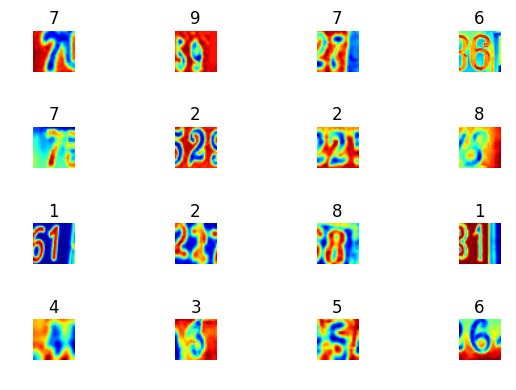

In [22]:
#plot random image with it's label
def plot_random_data(width = 4, height = 4):
    n_plot_imgs = width * height
#     label_names = [s.split("/")[-1] for s in train_folders]  #splitted ['A','B',..]

    for i in range(1, n_plot_imgs + 1):
        plt.subplot(height, width, i)
        plt.tight_layout()
        plt.axis("off")
        img_id = np.random.choice(train_labels_t.shape[0])
        plt.imshow(train_data_g[img_id, :, :])
        #img_label = label_names[train_labels[img_id]]
        img_label = train_labels_t[img_id]
        plt.title(img_label)
    plt.show()
    
plot_random_data()

In [23]:
#save processed data as name  of  SVHN.pickle
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    #'train_dataset': train_data_GCN,
    'train_labels': train_labels_t,
    'valid_dataset': valid_data_g,
    'valid_labels': valid_labels,
    'test_dataset': test_data_g,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    


In [24]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 258071253


In [25]:
#save processed train data(from first upto 200000)  to SVHN1.pickle
pickle_file = 'SVHN1.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset1': train_data_g[:200000],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    


In [26]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1638400161


In [27]:
#save processed train data part(from 200000,to 400000)  to SVHN2.pickle
pickle_file = 'SVHN2.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset2': train_data_g[200000:400000],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    


In [28]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1638400161


In [29]:
#save processed train data part(from 400000,to the end)  to SVHN3.pickle
pickle_file = 'SVHN3.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset3': train_data_g[400000:],
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    


In [30]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1216430241


#### f1-score for harmonic precision and racll of train_data and validation data

The f1-score is the harmonic mean of precision and recall. The scores corresponding to every class imply the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.

The support is the number of samples of the true response that lie in that class. 

In [31]:
clf = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                    epsilon=0.1,eta0=0.0, fit_intercept=True, l1_ratio=0.15,
                    learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=3,
                    penalty='l2', power_t=0.5, random_state=None, shuffle=True,
                    verbose=0, warm_start=False)
clf.fit(train_data_c.reshape(train_data_g.shape[0],-1), train_labels_t)

train_prediction = clf.predict(train_data_g.reshape(train_data_g.shape[0],-1))

valid_prediction = clf.predict(valid_data_g.reshape(valid_data_g.shape[0],-1))


print('Training score : ', clf.score(train_data_g.reshape(train_data_g.shape[0],-1), train_labels_t))

print('Validation score :', clf.score(valid_data_g.reshape(valid_data_g.shape[0],-1), valid_labels))

print('classification_report for training data:\n', classification_report(train_labels_t, train_prediction))

print('classification_report for validation data:\n', classification_report(valid_labels, valid_prediction))


Training score :  0.168719575562
Validation score : 0.167592592593
classification_report for training data:
              precision    recall  f1-score   support

          1       0.22      0.00      0.00    103821
          2       0.35      0.28      0.32     84725
          3       0.70      0.00      0.00     68662
          4       0.22      0.26      0.24     57491
          5       0.51      0.02      0.03     59772
          6       0.12      0.55      0.19     46709
          7       0.14      0.41      0.21     48992
          8       0.27      0.00      0.00     39803
          9       0.14      0.17      0.15     38515

avg / total       0.31      0.17      0.12    548490

classification_report for validation data:
              precision    recall  f1-score   support

          1       0.00      0.00      0.00       600
          2       0.22      0.21      0.22       600
          3       0.00      0.00      0.00       600
          4       0.21      0.22      0.21      

/home/ys/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
#open pickle  file containing each train, valid , test and class labels
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  #train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  #print('Training set', train_dataset.shape, train_labels.shape)
  #print('Validation set', valid_dataset.shape, valid_labels.shape)
  #print('Test set', test_dataset.shape, test_labels.shape)

In [33]:
pickle_file = 'SVHN1.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset1 = save['train_dataset1']
  del save  # hint to help gc free up memory

pickle_file = 'SVHN2.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset2 = save['train_dataset2']
  del save  # hint to help gc free up memory

pickle_file = 'SVHN3.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset3 = save['train_dataset3']
  del save  # hint to help gc free up memory

In [34]:
#test
print(train_dataset1.shape)
print(train_dataset2.shape)
print(train_dataset3.shape)
t1=np.ndarray(48).reshape(4,3,2,2)
print(t1.shape)
#print(t1)
t2=np.ndarray(48).reshape(4,3,2,2)

(200000, 32, 32)
(200000, 32, 32)
(148490, 32, 32)
(4, 3, 2, 2)


In [35]:
#concatenate  train_dataset1, train_dataset2 and train_dataset3
train_dataset = np.concatenate((train_dataset1, train_dataset2, train_dataset3), axis=0)
del train_dataset1, train_dataset2, train_dataset3
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (548490, 32, 32) (548490,)
Validation set (5400, 32, 32) (5400,)
Test set (26032, 32, 32) (26032,)


In [36]:
image_size = 32
num_labels = 10
num_channels = 1 # grayscale
#make 4 dimension array from 3-d
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = labels.astype(np.int32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (548490, 32, 32, 1) (548490,)
Validation set (5400, 32, 32, 1) (5400,)
Test set (26032, 32, 32, 1) (26032,)


In [37]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization"""
    """[http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf]"""

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gaussian_filter(filter_shape), borrow=True)
    filters = gaussian_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.sub(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X

    return new_X


def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in xrange(0, kernel_shape[2]):
        for i in xrange(0, kernel_shape[0]):
            for j in xrange(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [38]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])

In [93]:
print(test_dataset.shape)

(26032, 32, 32, 1)


####  CONVOLUTION NEURAL NETWORK TEST 1 : (1) dropout probability : 0.9375   (2) bias variable(tf.constant value): 0.0

In [88]:
with tf.device('/gpu:0'):
    graph = tf.Graph()
    with graph.as_default():
        ##Variables.
#         batch_size = 128 #mini batch for SGD
#         num_hidden = 1024
        #keep_probe = 0.9375  #probability of dropout : 2nd try
#        keep_probe =.5  #probability of dropout
#         image_size = 28
#         num_labels = 10
#         patch_size = 5
#         num_channel = 1 #grayscale
#         depth = 16     
        
        batch_size = 64
        patch_size = 5
        depth1 = 16
        depth2 = 32
        depth3 = 64
        num_hidden1 = 64
        num_hidden2 = 16
        shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
        
        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1)
            return tf.Variable(initial)
        
        def bias_variable(shape):
            initial = tf.constant(0.0, shape=shape)
            #initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
        print ("image_size:",image_size)    
        #input data for  the training data, We use placeholder that will be fed
        #at run time with a trainig minibatch                  
        #shape = (64,32,32,1)
        tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
        #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
        #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
        tf_test_dataset = tf.constant(test_dataset)
#         keep_prob = tf.placeholder(tf.float32)   
        
        #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]
        
        #weight_fully_conn1 = weight_variable([7*7*64,1024]) #
        weight_fully_conn1 = weight_variable([64,16]) #[num_hidden1, num_hidden2]
        bias_fully_conn1 = bias_variable([16]) #[num_hidden2]
        weight_fully_conn2 = weight_variable([16, 10]) #[num_hidden2,  num_labels]
        bias_fully_conn2 = bias_variable([10]) #[num_labels]
        
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
            print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
            print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn)
            #pool = max_pool_2x2(hidden)
            
            print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
            print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)
#             lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance
#             pool = max_pool_2x2(lrn)
            print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
            print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
            print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
            print("drop:",drop)
            ## original asf ##
            shape = hidden.get_shape().as_list() #[-1,7*7*64]
            
            print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            #flat = reshape_flat(hidden,shape)
            flat = reshape_flat(drop, shape)
            print("flat:",flat)
            hidden = relu2d(tf.matmul(flat, weight_fully_conn1),bias_fully_conn1)
            print("hidden:",hidden)
            #drop = dropout2d(hidden,keep_prob)  #original: before flat  
            #print("drop:",drop)
            #return softmax2d(tf.matmul(drop, weight_fully_conn2), bias_fully_conn2)
            #return tf.matmul(drop, weight_fully_conn2) + bias_fully_conn2
            return tf.matmul(hidden, weight_fully_conn2) + bias_fully_conn2
        #logits = model(tf_train_dataset, 0.5, shape) #test accuracy:85.9%
        #logits = model(tf_train_dataset, 0.925, shape)#test accuracy:87.3%
        #logits = model(tf_train_dataset, 0.936, shape)#test accuracy:87.1%
        logits = model(tf_train_dataset, 0.9375, shape)#test accuracy:87.4%
        #logits = model(tf_train_dataset, 0.95, shape)#test accuracy:87.3%
        #logits = model(tf_train_dataset, 1.0, shape)#test accuracy:86.6%
#omit regularization since  it is too complicated..!!        
        #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))    
        #Optimizer
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
        
        #Preditionsfor  the training , validationn  and test data.
#         train_prediction = tf.nn.softmax(logits)
#         valid_prediction = tf.nn.softmax(tf_valid_dataset)
#         test_prediction = tf.nn.softmax(tf_test_dataset)
        train_prediction = tf.nn.softmax(model(tf_train_dataset, 1.0, shape))
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0, shape))
        test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0, shape))
    
        saver = tf.train.Saver()


image_size: 32
lcn Tensor("truediv:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_2:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_3:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_1:0", shape=(64, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_4:0", shape=(64, 1, 1, 64), dtype=float32)
hidden3 Tensor("Relu_2:0", shape=(64, 1, 1, 64), dtype=float32)
drop: Tensor("dropout/mul:0", shape=(64, 1, 1, 64), dtype=float32)
shape: [64, 1, 1, 64]
flat: Tensor("Reshape:0", shape=(64, 64), dtype=float32)
hidden: Tensor("Relu_3:0", shape=(64, 16), dtype=float32)
lcn Tensor("truediv_1:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_7:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool_2:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_8:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_5:0", shape=(64, 10, 10, 32), dtype=floa

Initialized
Minibatch loss at step 0: 2.304640
Minibatch accuracy: 9.4%
Validation accuracy: 13.1%
Minibatch loss at step 500: 0.290424
Minibatch accuracy: 92.2%
Validation accuracy: 82.7%
Minibatch loss at step 1000: 0.414114
Minibatch accuracy: 85.9%
Validation accuracy: 84.8%
Minibatch loss at step 1500: 0.209040
Minibatch accuracy: 93.8%
Validation accuracy: 87.5%
Minibatch loss at step 2000: 0.222821
Minibatch accuracy: 93.8%
Validation accuracy: 88.2%
Minibatch loss at step 2500: 0.363746
Minibatch accuracy: 92.2%
Validation accuracy: 88.6%
Minibatch loss at step 3000: 0.236128
Minibatch accuracy: 93.8%
Validation accuracy: 88.8%
Minibatch loss at step 3500: 0.367091
Minibatch accuracy: 92.2%
Validation accuracy: 89.3%
Minibatch loss at step 4000: 0.212728
Minibatch accuracy: 95.3%
Validation accuracy: 89.6%
Minibatch loss at step 4500: 0.142841
Minibatch accuracy: 98.4%
Validation accuracy: 89.6%
Minibatch loss at step 5000: 0.176912
Minibatch accuracy: 95.3%
Validation accuracy

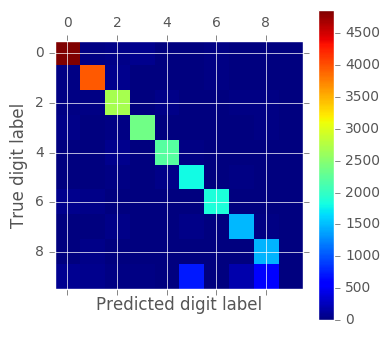

Model saved in file: CNN_1.ckpt


In [101]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0): 
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  print(type(test_prediction.eval())) 
  #classification  report for precision , recall f1-score  
  print('Classification report of test data:\n', classification_report(test_labels, np.argmax(test_prediction.eval(), 1))) 
  #show confusion matrix to check digit number-wise prediction accuracy vs. digit number skewness 
  ca = confusion_matrix(test_labels, np.argmax(test_prediction.eval(), 1))
  print("Confusion matrix\n",ca)  
  print()
  print("Confusion matrix\n")   
  plt.matshow(ca)
  #plt.title('Confusion matrix')
  plt.colorbar()
  plt.ylabel('True digit label')
  plt.xlabel('Predicted digit label')
  plt.show()
  
  
  save_path = saver.save(session, "CNN_1.ckpt") 
  print("Model saved in file: %s" % save_path)  